In [1]:
import healpy as hp
import numpy as np
from tilepy.include.MapManagement import MapReader, SkyMap
# Import main packages 
from tilepy.include.ObservationScheduler import GetSchedule
from tilepy.include.PointingTools import ObservationParameters, NextWindowTools
import time
import argparse
import os
from pathlib import Path
import datetime

/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
# The url to the FITS file with the sky localization in a healpix format (fits file with name starting by glg_healpix
skymap = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2024/bn240612503/current/glg_healpix_all_bn240612503_v00.fit'

# Date and time of the event in format YYYY-MM-DD HH:MM:SS. You can use 2023-07-15 14:30:10 for the example .fits file
obsTime = datetime.datetime.fromisoformat("2023-06-10 14:51:47")

# Path to the input datasets (where galaxy cat should be for GW case)
datasetDir = '../../tilepy/dataset/'

# Path to the output folder
outDir = './output'

# Config file for the tiling scheduling
cfgFile = '../config/FollowupParameters_CTAOS.ini'

# Tiles already observed
pointingsFile = None
#pointingsFile = './output/bn240612503/PGinFoV/SuggestedPointings_2DProbOptimisation.txt'


In [3]:


obspar_gauss = ObservationParameters()
obspar_gauss.add_parsed_args(None,obsTime,datasetDir,None,outDir,pointingsFile)
obspar_gauss.from_configfile(cfgFile)
obspar_gauss.mode = "gaussian"
obspar_gauss.ra = 312.89
obspar_gauss.dec = 4.5
obspar_gauss.sigma_deg = 3.
obspar_gauss.nside = 512



In [4]:
raw_map = MapReader(obspar_gauss)

skymap = SkyMap(obspar_gauss, raw_map)


In [5]:
gaussian_map = raw_map.getMap("prob")

In [6]:
skymap.getArea(0.9)

<Quantity 0.03958389 deg2>

Starting the 2D pointing calculation with the following parameters

Filename:  Gaussian_RA312.89_Dec4.5
Date:  2023-06-10 14:51:47
Previous pointings:  None
Dataset:  ../../tilepy/dataset/
Output:  ./output/Gaussian_RA312.89_Dec4.5

============== Main parsed observation parameters ==============  
Observatory Name: CTAO-S
Event Name: None
Observatory: -24.5 deg
Observatory: -70.17 deg
Observatory: 2635.0 m
Max zenith: 60
Using Greytime is: True
FOV: 4.0
Max runs: 20
Duration: 20
High Resolution NSIDE: 512
Low Resolution NSIDE: 128
The strategy is (3D, integrated, mangrove=False)
The level of details is (doPlot=True, doRank = True)


-------------------   NEW EVENT   --------------------

----------   NEW FOLLOW-UP ATTEMPT   ----------

Total GW probability covered:  0.9803 Number of runs that fulfill darkness condition  : 32 Number of effective pointings:  7

================================= Tiling found =============================================
     Time[UTC]      RA[deg]  DEC[d

/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


./output/Gaussian_RA312.89_Dec4.5/PGinFoV
Loading pointings from ./output/Gaussian_RA312.89_Dec4.5/PGinFoV/SuggestedPointings_2DProbOptimisation.txt
----------   PLOTTING THE SCHEDULING   ----------
Total covered probability with the scheduled tiles is PGW= 0.98030
No galaxies given


/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


No galaxies given for plot 2


/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format 

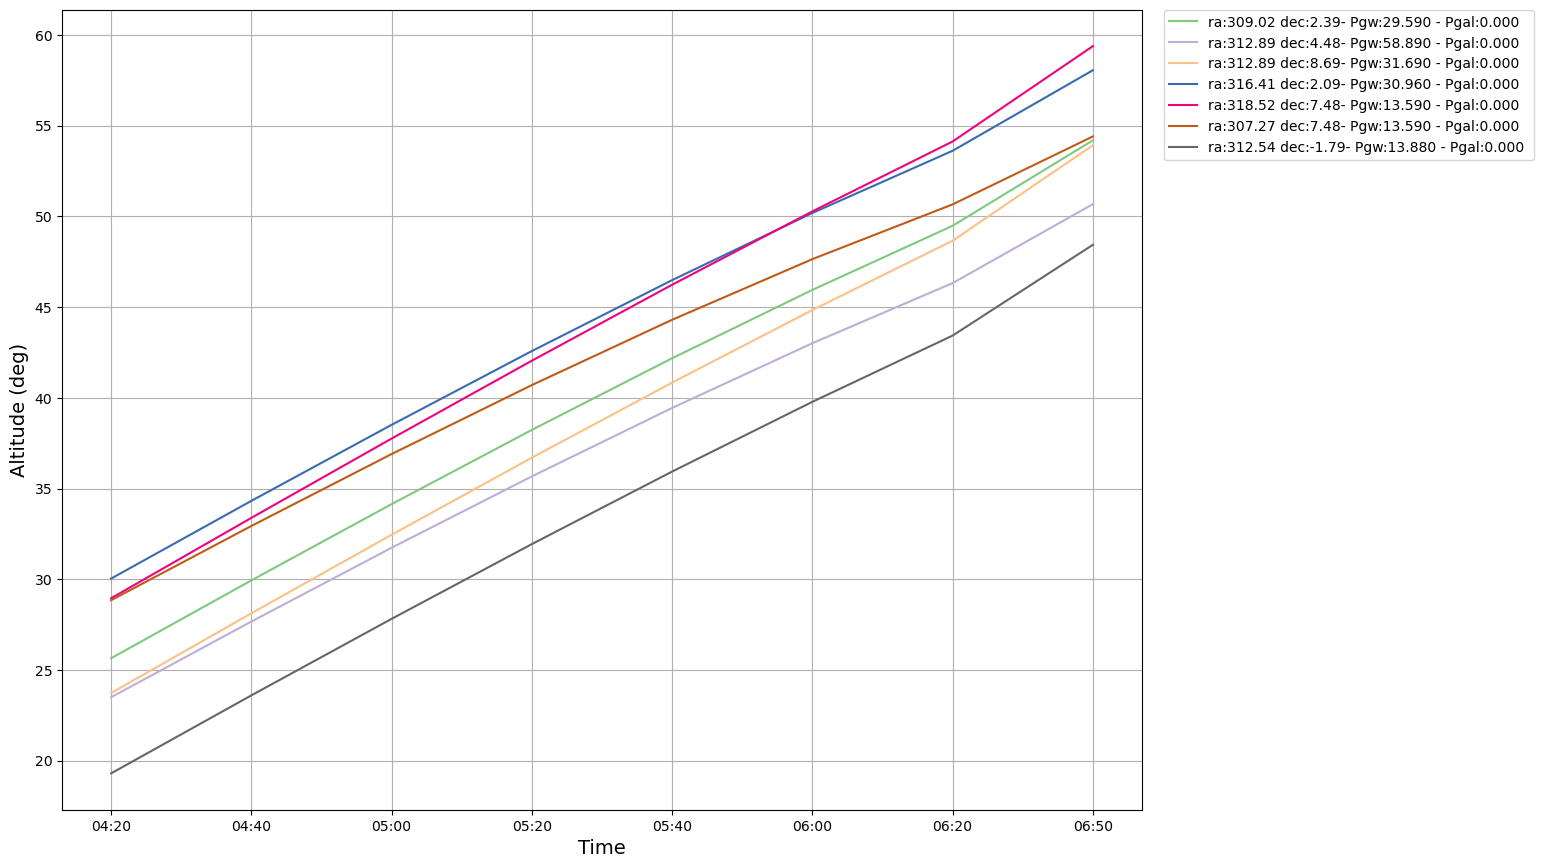

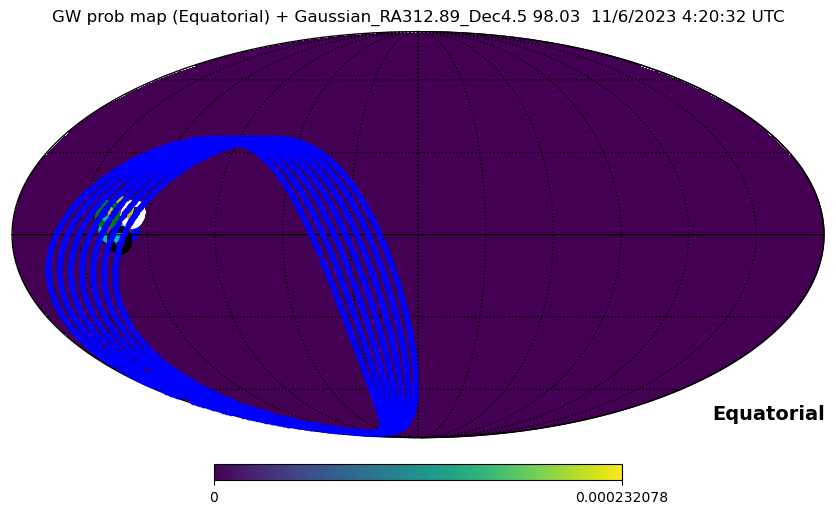

In [7]:
GetSchedule(obspar_gauss)

In [8]:
class ObsParams:
    mode = "file"
    skymap = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2024/bn240612503/current/glg_healpix_all_bn240612503_v00.fit'  # Path to the GBM FITS file
    event_name = "gbm_event"
    downloadMaxRetry = 10
    downloadWaitPeriodRetry = 60

obspar = ObsParams()
reader = MapReader(obspar)

# Retrieve the GBM probability map
gbm_map = reader.getMap("prob")

The file is already existing, it will be re-downloaded


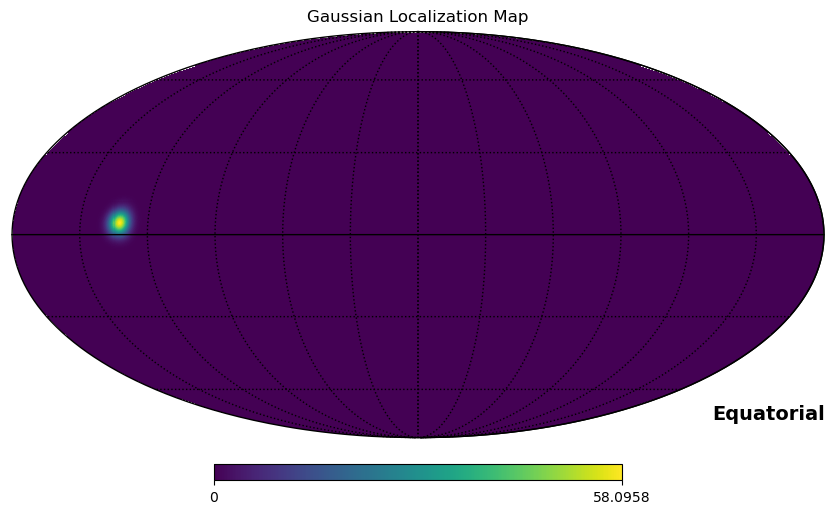

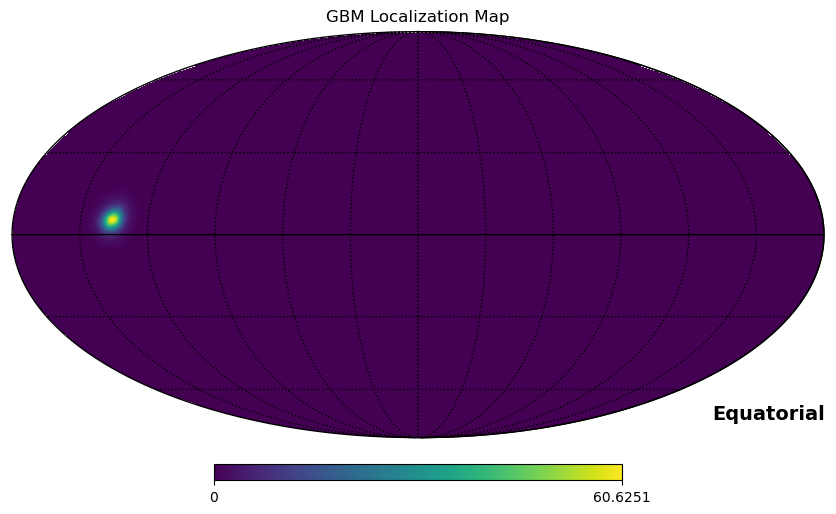

In [9]:
import matplotlib.pyplot as plt

# Plot Gaussian Localization Map
hp.mollview(gaussian_map.data, title="Gaussian Localization Map", rot=[180, 0],
            coord="C", nest = True)
hp.graticule()

# Plot GBM Localization Map
hp.mollview(gbm_map.data, title="GBM Localization Map",rot=[180, 0],
            coord="C",nest = True)
hp.graticule()

plt.show()